In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import roc_curve, precision_recall_curve, det_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

In [3]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Rescaling, Dense, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.utils import to_categorical

# Introduction

Datahack URL: https://datahack.analyticsvidhya.com/contest/gender-classification/

In [4]:
train = pd.read_csv('train.csv')

In [5]:
test = pd.read_csv('test.csv')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12196 entries, 0 to 12195
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_names  12196 non-null  object
 1   class        12196 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 190.7+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5227 entries, 0 to 5226
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_names  5227 non-null   object
dtypes: object(1)
memory usage: 41.0+ KB


In [8]:
# import shutil
# for i in test['image_names']:
#     shutil.move('train/' + i, 'test/' + i)

In [9]:
train.head()

,image_names,class
0,11413.jpg,1
1,9863.jpg,1
2,997.jpg,0
3,5950.jpg,0
4,10454.jpg,1


In [10]:
train.sort_values(by='image_names')

,image_names,class
10086,0.jpg,0
2566,100.jpg,0
2315,1000.jpg,0
11295,10000.jpg,1
7553,10001.jpg,1
...,...,...
3962,9990.jpg,1
1915,9993.jpg,1
3453,9994.jpg,1
9773,9995.jpg,1


In [11]:
train['class'].value_counts()

class
1    6174
0    6022
Name: count, dtype: int64

# Batch Loading

In [12]:
labels_list = list(train.sort_values(by='image_names')['class'].values)

In [13]:
len(labels_list)

12196

In [14]:
rng = np.random.default_rng()

In [15]:
for i in range(1):
    image_name = train['image_names'][rng.integers(len(labels_list))]
    img = plt.imread('train/'+image_name)
    print(np.array(img).shape)

(224, 224, 3)


In [16]:
batch_size = 128

In [17]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(directory='train/', 
                                            labels=labels_list, batch_size=batch_size, 
                                            image_size=(224, 224), shuffle=True,
                                            seed=42, validation_split=0.25, subset='both')

Found 12196 files belonging to 2 classes.
Using 9147 files for training.
Using 3049 files for validation.


In [18]:
train_ds.class_names

[0, 1]

In [24]:
y_test = tf.concat([y for x, y in test_ds], axis=0).numpy()

In [26]:
y_test.size

3049

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

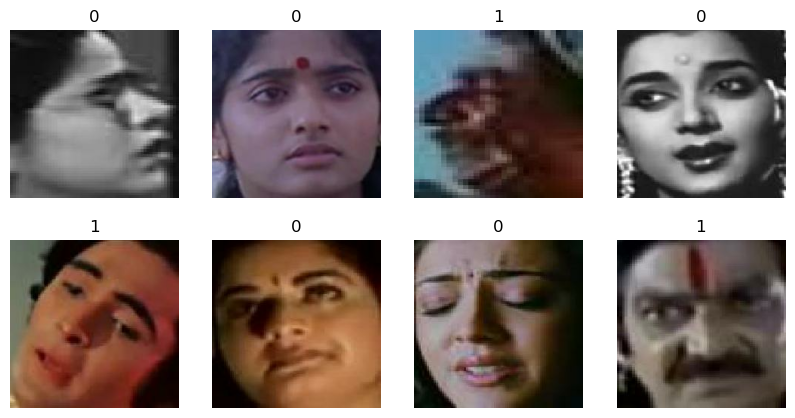

In [20]:
plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
    for i in range(8):
        random_number = rng.integers(len(images))
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[random_number].numpy().astype("uint8"))
        plt.title(labels.numpy()[random_number])
        plt.axis("off")

In [21]:
list(train_ds.take(1).as_numpy_iterator())[0][0].shape

(128, 224, 224, 3)

In [22]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 224, 224, 3)
(128,)


In [23]:
for image_batch, labels_batch in train_ds.take(1):
    input_size = image_batch.shape.as_list()

# Model

In [25]:
model=Sequential()
model.add(Rescaling(1./255))
model.add(Flatten())
model.add(Dense(units=25, activation='relu', kernel_initializer=HeNormal()))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())
model.add(Dense(units=25, activation='relu', kernel_initializer=HeNormal()))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())
model.add(Dense(units=25, activation='relu', kernel_initializer=HeNormal()))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())
model.add(Dense(units=1, activation='sigmoid'))

In [25]:
model.build(input_shape=input_size)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (1024, 224, 224, 3)       0         
                                                                 
 flatten (Flatten)           (1024, 150528)            0         
                                                                 
 dense (Dense)               (1024, 25)                3763225   
                                                                 
 dropout (Dropout)           (1024, 25)                0         
                                                                 
 batch_normalization (BatchN  (1024, 25)               100       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (1024, 25)                650       
                                                        

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [28]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=20, verbose=1, 
                           mode='max', baseline=0.5, restore_best_weights=True, start_from_epoch=10),
             ModelCheckpoint(filepath='model.hdf5', monitor='val_binary_accuracy', verbose=0,
                             mode='max', save_best_only=True)]

In [29]:
history = model.fit(train_ds, epochs=20, callbacks=callbacks, validation_data=test_ds)

Epoch 1/20
9/9 [==============================] - 30s 3s/step - loss: 0.8027 - binary_accuracy: 0.5335 - val_loss: 0.6761 - val_binary_accuracy: 0.7576
Epoch 2/20
9/9 [==============================] - 33s 4s/step - loss: 0.7572 - binary_accuracy: 0.5549 - val_loss: 0.5541 - val_binary_accuracy: 0.7425
Epoch 3/20
9/9 [==============================] - 20s 2s/step - loss: 0.7315 - binary_accuracy: 0.5638 - val_loss: 0.6093 - val_binary_accuracy: 0.6917
Epoch 4/20
9/9 [==============================] - 19s 2s/step - loss: 0.7203 - binary_accuracy: 0.5677 - val_loss: 0.7091 - val_binary_accuracy: 0.5425
Epoch 5/20
9/9 [==============================] - 17s 2s/step - loss: 0.7022 - binary_accuracy: 0.5803 - val_loss: 0.7499 - val_binary_accuracy: 0.4743
Epoch 6/20
9/9 [==============================] - 17s 2s/step - loss: 0.7024 - binary_accuracy: 0.5658 - val_loss: 0.8169 - val_binary_accuracy: 0.3752
Epoch 7/20
9/9 [==============================] - 17s 2s/step - loss: 0.6877 - binary_ac

In [74]:
history = model.fit(X_train, y_train, batch_size=1024, epochs=50, callbacks=callbacks, 
                    validation_data=(X_test, y_test), )

Epoch 1/50
9/9 [==============================] - 37s 3s/step - loss: 0.8380 - binary_accuracy: 0.5271 - val_loss: 1.8674 - val_binary_accuracy: 0.6177
Epoch 2/50
9/9 [==============================] - 25s 3s/step - loss: 0.7539 - binary_accuracy: 0.5701 - val_loss: 2.1422 - val_binary_accuracy: 0.5264
Epoch 3/50
9/9 [==============================] - 26s 3s/step - loss: 0.6996 - binary_accuracy: 0.6105 - val_loss: 0.9656 - val_binary_accuracy: 0.6499
Epoch 4/50
9/9 [==============================] - 28s 3s/step - loss: 0.6794 - binary_accuracy: 0.6220 - val_loss: 0.8259 - val_binary_accuracy: 0.6382
Epoch 5/50
9/9 [==============================] - 27s 3s/step - loss: 0.6533 - binary_accuracy: 0.6500 - val_loss: 0.6227 - val_binary_accuracy: 0.7057
Epoch 6/50
9/9 [==============================] - 26s 3s/step - loss: 0.6316 - binary_accuracy: 0.6598 - val_loss: 0.5398 - val_binary_accuracy: 0.7417
Epoch 7/50
9/9 [==============================] - 23s 3s/step - loss: 0.6107 - binary_ac

In [78]:
model = load_model('model.hdf5')

In [30]:
prediction = model.predict(test_ds)

3/3 [==============================] - 1s 328ms/step


In [31]:
prediction_cat = (prediction >= 0.5).astype(int)

In [32]:
y_test = tf.concat([y for x, y in test_ds], axis=0).numpy()

In [33]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.43      0.90      0.58       739
           1       0.95      0.62      0.75      2310

    accuracy                           0.69      3049
   macro avg       0.69      0.76      0.67      3049
weighted avg       0.83      0.69      0.71      3049



In [82]:
history_df = pd.DataFrame(history.history)

In [83]:
history_df.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.838042,0.527117,1.867412,0.617655
1,0.753922,0.570107,2.142176,0.526373
2,0.699558,0.610519,0.965587,0.649904
3,0.679424,0.621998,0.825949,0.638152
4,0.653290,0.649994,0.622747,0.705657


Text(0.5, 0.01, 'epochs')

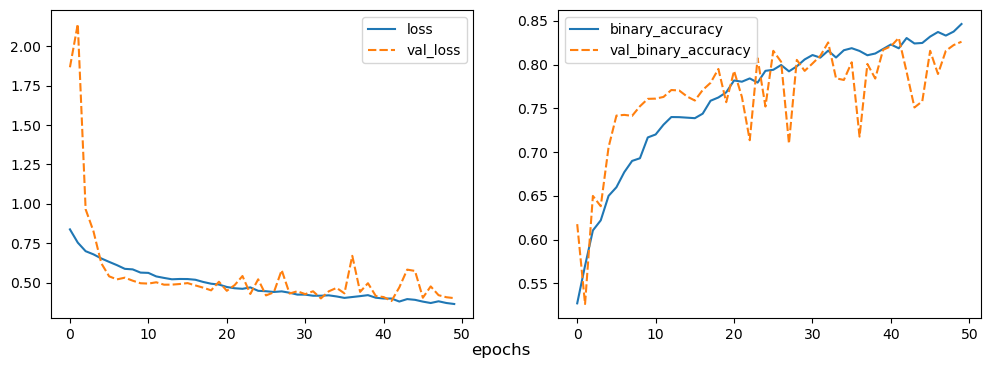

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

actual class 0, predicted probability 0.22141164541244507


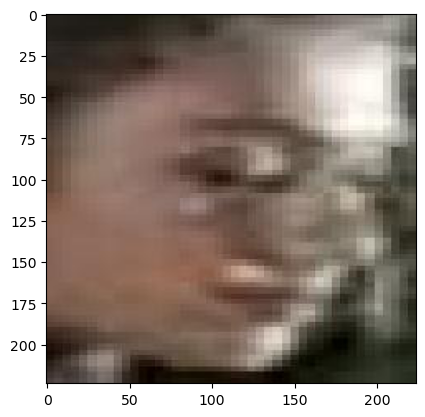

In [93]:
index = rng.integers(X_test.shape[0])
plt.imshow(np.reshape(X[index], (224,224,3)))
print(f'actual class {train["class"].loc[index]}, predicted probability {prediction[index][0]}')

# CNN

In [25]:
model = Sequential()
model.add(Rescaling(1./255))
model.add(Conv2D(filters=25, kernel_size=(5,5), dilation_rate=(1,1), strides=(2,2), padding='valid'))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(4,4), padding='valid'))

model.add(Conv2D(filters=25, kernel_size=(5,5), dilation_rate=(1,1), strides=(2,2), padding='valid'))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(4,4), padding='valid'))

model.add(Flatten())
model.add(Dense(units=25, activation='relu'))
model.add(Dropout(rate=0.4))
model.add(BatchNormalization())
model.add(Dense(units=1, activation='sigmoid'))

In [26]:
model.build(input_shape=input_size)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (128, 224, 224, 3)        0         
                                                                 
 conv2d (Conv2D)             (128, 110, 110, 25)       1900      
                                                                 
 leaky_re_lu (LeakyReLU)     (128, 110, 110, 25)       0         
                                                                 
 max_pooling2d (MaxPooling2  (128, 27, 27, 25)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (128, 12, 12, 25)         15650     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (128, 12, 12, 25)         0         
                                                        

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [29]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=20, verbose=1, 
                           mode='max', baseline=0.5, restore_best_weights=True, start_from_epoch=5),
             ModelCheckpoint(filepath='model_cnn.h5', monitor='val_binary_accuracy', verbose=0,
                             mode='max', save_best_only=True)]

In [29]:
history = model.fit(train_ds, epochs=20, callbacks=callbacks, validation_data=test_ds)

Epoch 1/20
9/9 [==============================] - 141s 12s/step - loss: 0.7230 - binary_accuracy: 0.5466 - val_loss: 0.7046 - val_binary_accuracy: 0.4795
Epoch 2/20
9/9 [==============================] - 84s 9s/step - loss: 0.6612 - binary_accuracy: 0.6107 - val_loss: 0.6814 - val_binary_accuracy: 0.5146
Epoch 3/20
9/9 [==============================] - 90s 10s/step - loss: 0.5965 - binary_accuracy: 0.6836 - val_loss: 0.6736 - val_binary_accuracy: 0.7327
Epoch 4/20
9/9 [==============================] - 95s 11s/step - loss: 0.5540 - binary_accuracy: 0.7266 - val_loss: 0.6672 - val_binary_accuracy: 0.7616
Epoch 5/20
9/9 [==============================] - 81s 9s/step - loss: 0.5209 - binary_accuracy: 0.7510 - val_loss: 0.6600 - val_binary_accuracy: 0.7773
Epoch 6/20
5/9 [===============>..............] - ETA: 32s - loss: 0.4948 - binary_accuracy: 0.7768

KeyboardInterrupt: 

In [66]:
model = load_model('model_cnn.h5')

In [64]:
prediction = model.predict(test_ds)

3/3 [==============================] - 6s 2s/step


In [65]:
prediction_cat = (prediction >= 0.5).astype(int)

In [32]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1772
           1       0.90      0.89      0.89      1887

    accuracy                           0.89      3659
   macro avg       0.89      0.89      0.89      3659
weighted avg       0.89      0.89      0.89      3659



In [33]:
history_df = pd.DataFrame(history.history)

In [34]:
history_df.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.715969,0.554059,0.701564,0.484285
1,0.657934,0.612862,0.677144,0.529653
2,0.598907,0.680450,0.670061,0.721235
3,0.569238,0.708797,0.662668,0.758951
4,0.539220,0.740893,0.654873,0.751025


Text(0.5, 0.01, 'epochs')

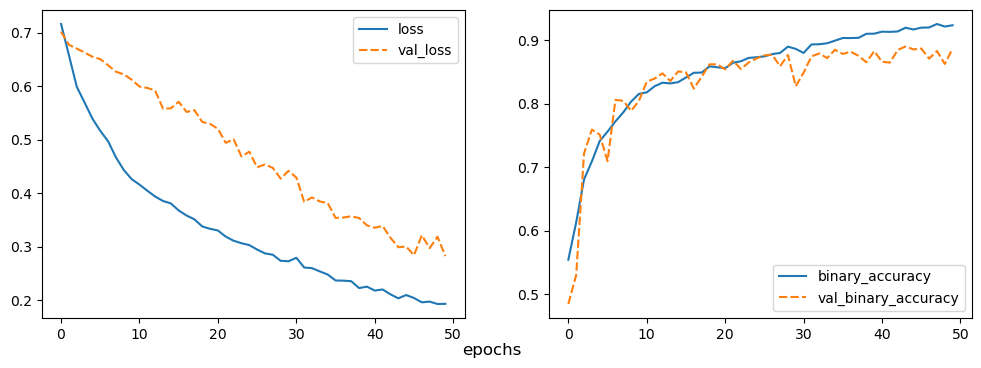

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

actual class 1, predicted probability 0.8938040137290955


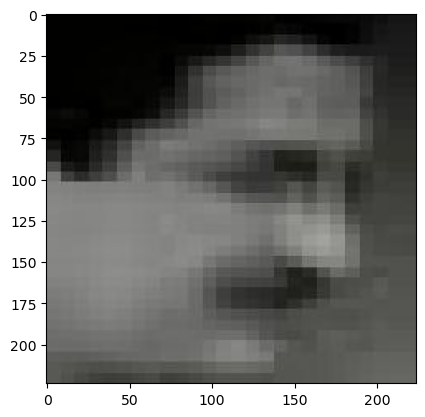

In [40]:
index = rng.integers(X_test.shape[0])
plt.imshow(np.reshape(X[index], (224,224,3)))
print(f'actual class {train["class"].loc[index]}, predicted probability {prediction[index][0]}')

# Transfer Learning

https://github.com/YaleDHLab/vggface

In [27]:
from keras_vggface.vggface import VGGFace

In [28]:
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))

In [29]:
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))

In [30]:
base_model = VGGFace(model='senet50')

In [31]:
base_model.summary()

Model: "vggface_senet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1/7x7_s2 (Conv2D)       (None, 112, 112, 64)         9408      ['input_1[0][0]']             
                                                                                                  
 conv1/7x7_s2/bn (BatchNorm  (None, 112, 112, 64)         256       ['conv1/7x7_s2[0][0]']        
 alization)                                                                                       
                                                                                                  
 activation (Activation)     (None, 112, 112, 64)         0         ['conv1/7x7_s2/b

In [32]:
len(base_model.layers)

288

In [33]:
base_model.layers[-10:]

In [34]:
for layer in base_model.layers:
    layer.trainable = False

In [35]:
dense = Dense(25, activation='relu')(base_model.layers[-2].output)
y = Dense(2, activation='softmax')(dense)

In [36]:
model = Model(inputs=base_model.input, outputs=y)

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [38]:
callbacks = [EarlyStopping(monitor='val_categorical_accuracy', min_delta=.001, patience=10, verbose=1, 
                           mode='max', baseline=0.5, restore_best_weights=True, start_from_epoch=5),
             ModelCheckpoint(filepath='model_tl.h5', monitor='val_categorical_accuracy', verbose=0,
                             mode='max', save_best_only=True)]

In [39]:
history = model.fit(train_ds, epochs=2, validation_data=test_ds)

Epoch 1/2
72/72 [==============================] - 996s 14s/step - loss: 0.2016 - categorical_accuracy: 0.9147 - val_loss: 0.1146 - val_categorical_accuracy: 0.9475
Epoch 2/2
72/72 [==============================] - 1056s 15s/step - loss: 0.1141 - categorical_accuracy: 0.9453 - val_loss: 0.1092 - val_categorical_accuracy: 0.9515


In [41]:
prediction = model.predict(test_ds)

24/24 [==============================] - 230s 10s/step


In [42]:
prediction_cat = (prediction >= 0.5).astype(int)

In [45]:
prediction_cat

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [0, 1],
       [0, 1]])

In [46]:
print(classification_report(y_test, prediction_cat[:, 1]))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1462
           1       0.95      0.96      0.95      1587

    accuracy                           0.95      3049
   macro avg       0.95      0.95      0.95      3049
weighted avg       0.95      0.95      0.95      3049



# test

In [69]:
test = tf.keras.utils.image_dataset_from_directory(directory='test/', 
                                            labels=None, batch_size=batch_size, 
                                            image_size=(224, 224), shuffle=False,
                                            seed=42)

Found 5227 files belonging to 1 classes.


In [71]:
file_names = [path[5:] for path in test.file_paths]

In [64]:
AUTOTUNE = tf.data.AUTOTUNE

test = test.cache().prefetch(buffer_size=AUTOTUNE)

In [49]:
test_X = []
for image_name in test['image_names']:
    img = plt.imread('images/' + image_name)
    test_X.append(img)
test_X = np.array(test_X)

In [65]:
test_pred = model.predict(test)

41/41 [==============================] - 376s 9s/step


In [66]:
test_pred_cat = (test_pred >= 0.5).astype(int)

In [67]:
test_pred_cat.shape

(5227, 2)

In [72]:
result = pd.DataFrame({'image_names': file_names,
                       'class': test_pred_cat[:, 1].flatten()})

In [73]:
result.to_csv('submission1.csv', index=False)

# Visualizations

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 110, 110, 25)      1900      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 110, 110, 25)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 25)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 25)        15650     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 12, 12, 25)        0         
                                                        

In [68]:
model.layers

In [69]:
model.layers[2].name

'leaky_re_lu'

In [70]:
model.layers[1].get_config()

{'name': 'conv2d',
 'trainable': True,
 'dtype': 'float32',
 'filters': 25,
 'kernel_size': (5, 5),
 'strides': (2, 2),
 'padding': 'valid',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'groups': 1,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

## filters

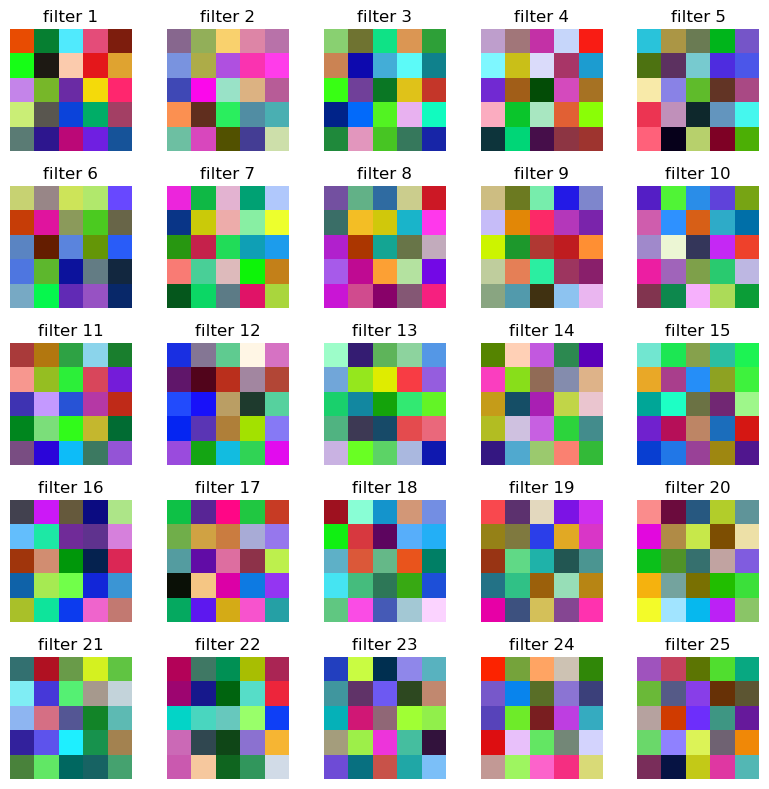

In [73]:
plt.figure(figsize=(8,8))
for i in range(25):
    layer_weights = model.get_layer(index=1).get_weights()[0][:,:,:,i]
    layer_weights -= layer_weights.min()
    layer_weights /= layer_weights.max()
    plt.subplot(5, 5, i+1)
    plt.imshow(layer_weights)
    plt.title('filter ' + str(i+1))
    plt.axis('off')
plt.tight_layout()

## intermediate layers

In [83]:
list(train_ds.take(1).as_numpy_iterator())[0][0].shape

(128, 224, 224, 3)

In [89]:
list(train_ds.take(1).as_numpy_iterator())[0][0][1].shape

(224, 224, 3)

In [144]:
images_list = list(train_ds.take(1).as_numpy_iterator())[0][0]/255

In [90]:
image = list(train_ds.take(1).as_numpy_iterator())[0][0][1]

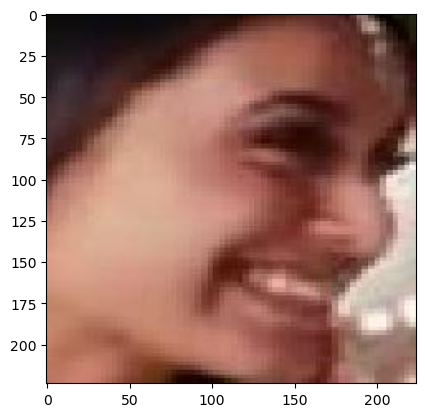

In [145]:
plt.imshow(images_list[7])

In [91]:
image.shape

(224, 224, 3)

In [98]:
image = np.expand_dims(image, axis=0)

In [99]:
image.shape

(1, 224, 224, 3)

In [100]:
[i.name for i in model.layers]

['rescaling',
 'conv2d',
 'leaky_re_lu',
 'max_pooling2d',
 'conv2d_1',
 'leaky_re_lu_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'dropout',
 'batch_normalization',
 'dense_1']

In [121]:
layer_names = [i.name for i in model.layers][1:7]

In [122]:
outputs = []

In [123]:
for layer_name in layer_names:
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    outputs.append(intermediate_layer_model.predict(image))

1/1 [==============================] - 0s 51ms/step


In [120]:
outputs[0].shape

(1, 110, 110, 25)

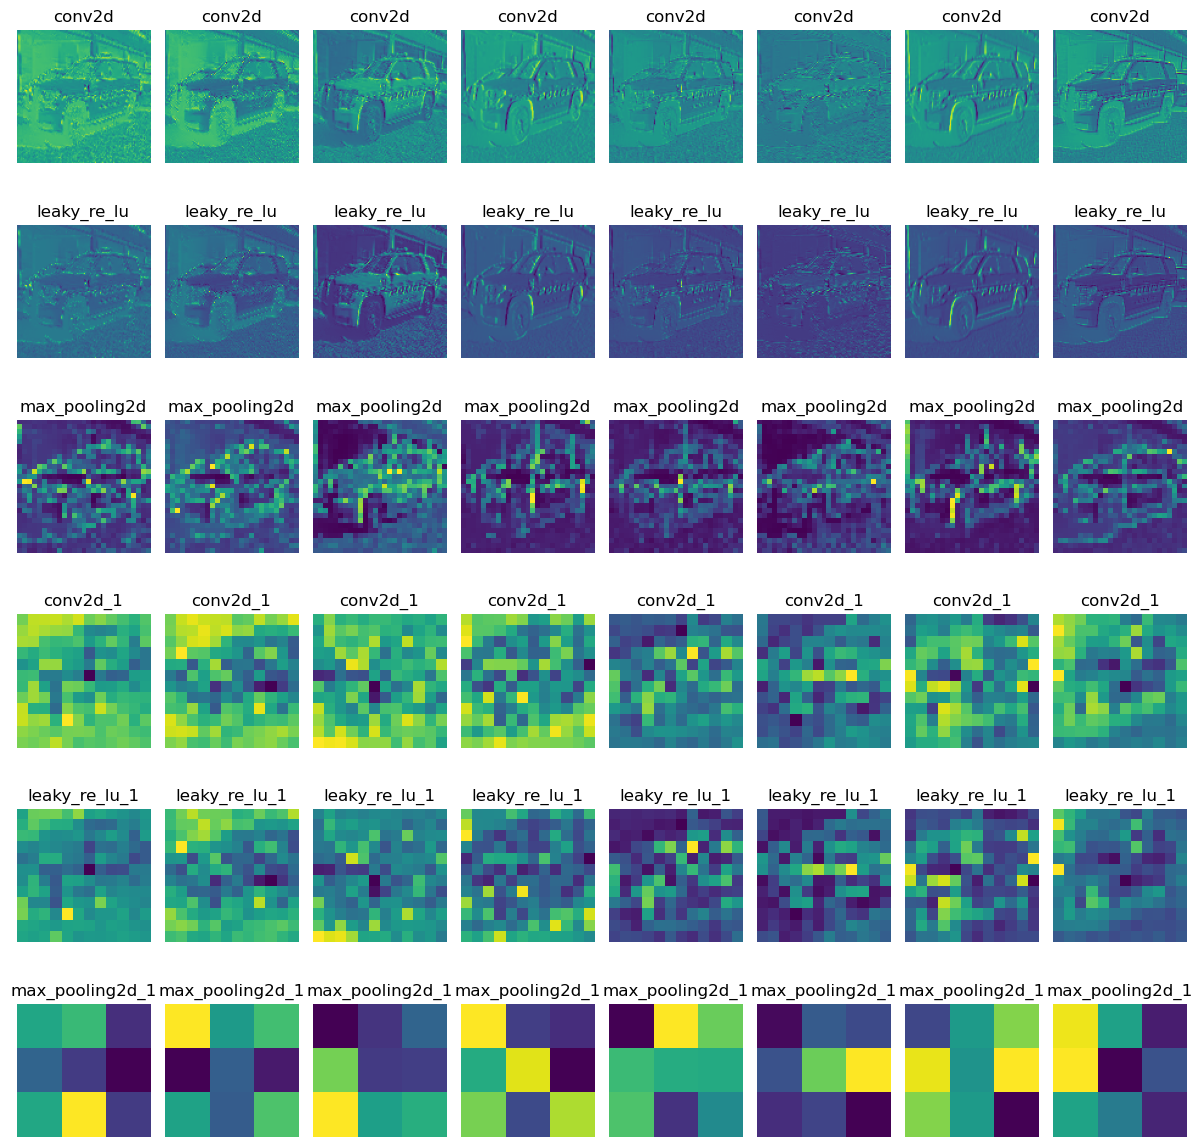

In [52]:
fig, axs = plt.subplots(6,8,figsize=(12,12))
for i in range(6):
    for z in range(8):
        axs[i][z].imshow(outputs[i][0,:,:,z])
        axs[i][z].set_title(layer_names[i])
        axs[i][z].axis('off')
plt.tight_layout()

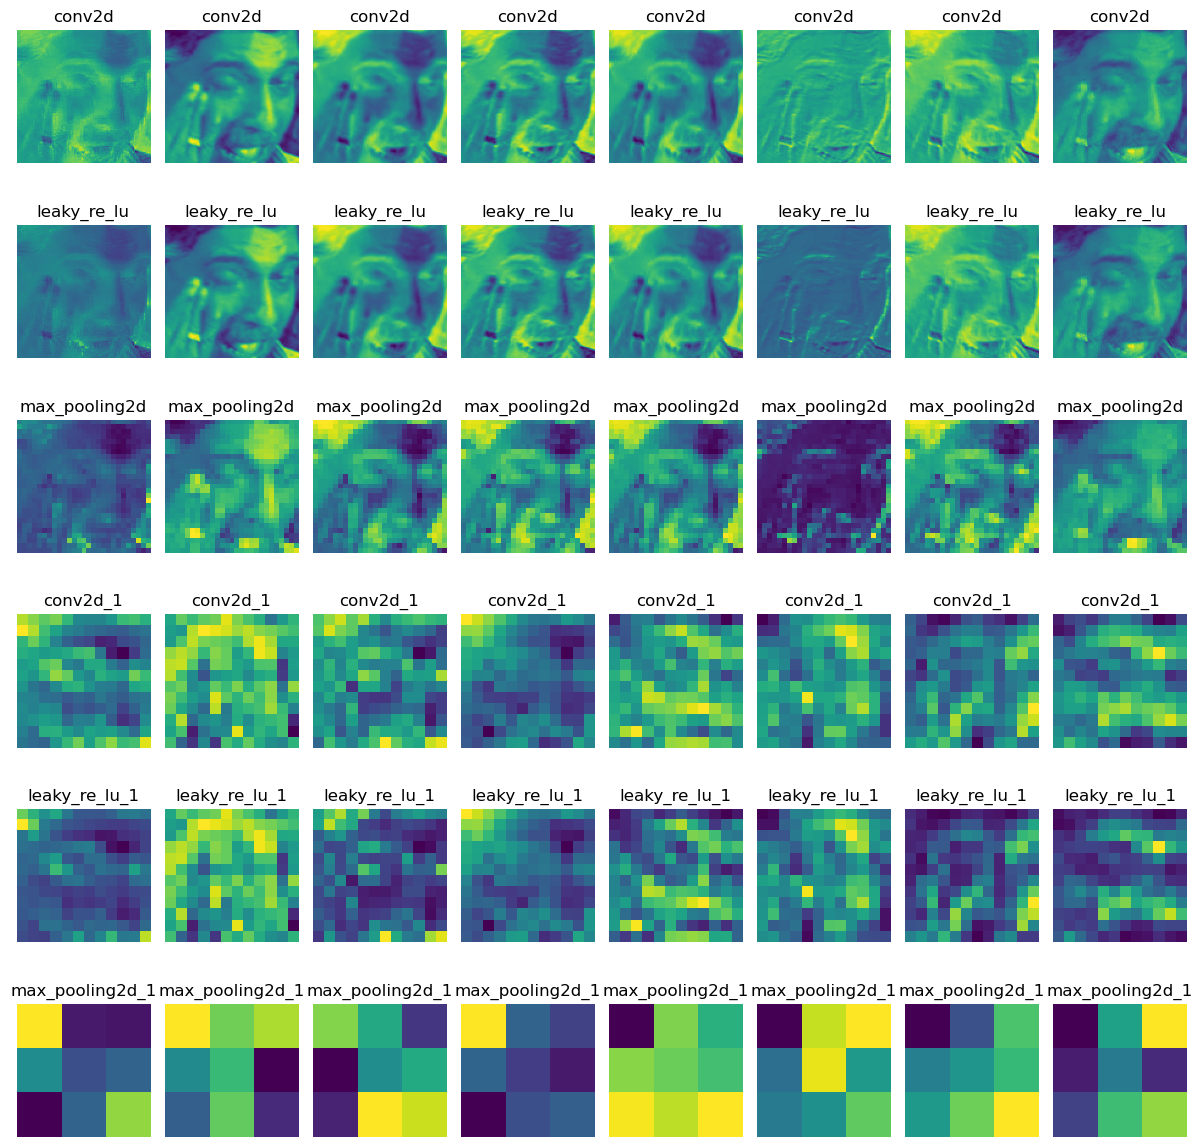

In [124]:
fig, axs = plt.subplots(6,8,figsize=(12,12))
for i in range(6):
    for z in range(8):
        axs[i][z].imshow(outputs[i][0,:,:,z])
        axs[i][z].set_title(layer_names[i])
        axs[i][z].axis('off')
plt.tight_layout()

## salience map

In [126]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear, ExtractIntermediateLayer
from tf_keras_vis.utils.scores import CategoricalScore, BinaryScore
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress

In [127]:
from matplotlib import cm

In [128]:
saliency = Saliency(model, model_modifier=ReplaceToLinear(), clone=True)

In [129]:
saliency_map = saliency(BinaryScore(1.0), image, smooth_samples=20, smooth_noise=0.2)

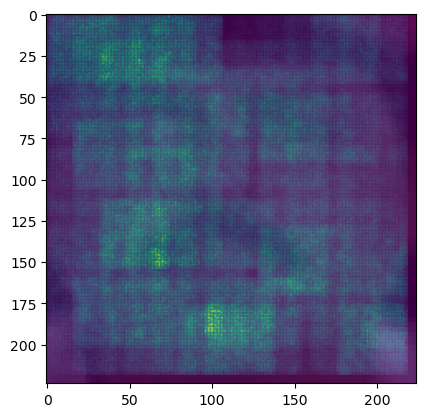

In [170]:
plt.imshow(images_list[12])
plt.imshow(saliency_map[0], alpha=0.8)

In [148]:
gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)

In [149]:
cam = gradcam(BinaryScore(1.0), image, penultimate_layer=-1)

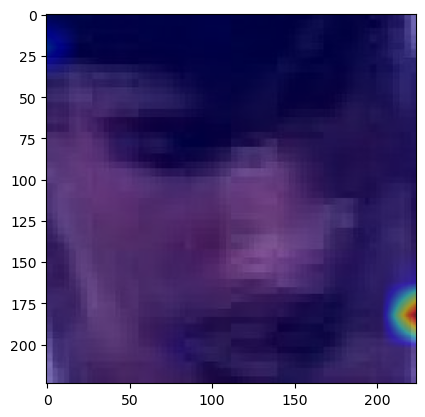

In [153]:
plt.imshow(images_list[19])
plt.imshow(np.uint8(cm.jet(cam[0])[..., :3] * 255), alpha=0.5)

In [154]:
gradcam_plusplus = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), clone=True)

In [155]:
cam_plusplus = gradcam_plusplus(BinaryScore(1.0), image, penultimate_layer=-1)

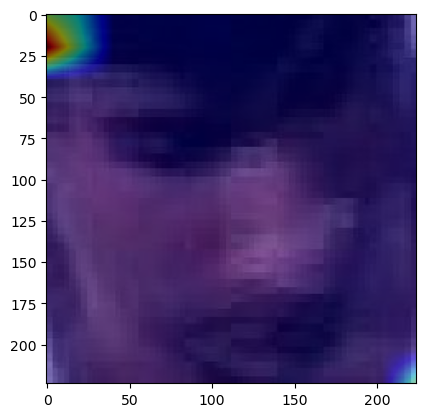

In [160]:
plt.imshow(images_list[19])
plt.imshow(np.uint8(cm.jet(cam_plusplus[0])[..., :3] * 255), alpha=0.5)

## activation maximization

In [162]:
model.layers[1].name

'conv2d'

In [163]:
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=model.layers[1].name)


In [164]:
activation_maximization = ActivationMaximization(model, 
                                            model_modifier=[extract_intermediate_layer, ReplaceToLinear()],
                                            clone=False)

In [165]:
activations = activation_maximization(CategoricalScore(0), callbacks=[Progress()])

200/200 [==============================] - 9s 44ms/step - Score: -0.0747 - TotalVariation2D: 4.3763 - Norm: 38.0367


In [166]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

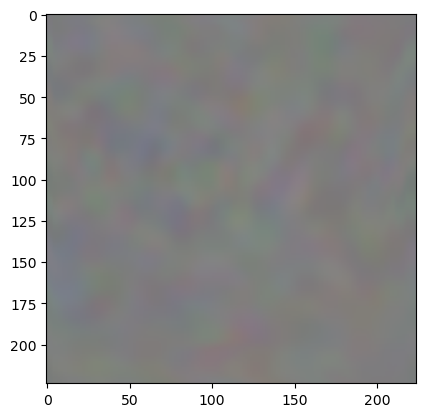

In [167]:
plt.imshow(activations[0].astype(np.uint8))

## occlusion map

In [168]:
def iter_occlusion(image, size=4):
    # taken from https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps

    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
    occlusion_center = np.full((size, size, 1), [0.5], np.float32)
    occlusion_padding = size * 2

    # print('padding...')
    image_padded = np.pad(image, ( \
    (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
    ), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()

            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
             x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
             = occlusion

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

            yield x - occlusion_padding, y - occlusion_padding, \
             tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]


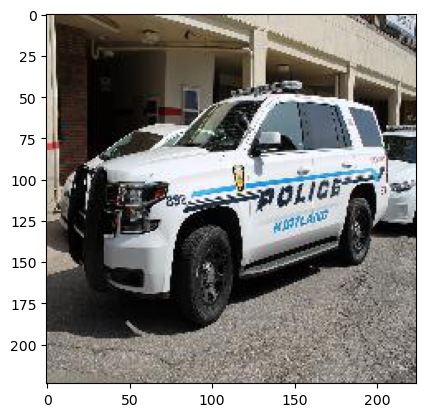

[None]

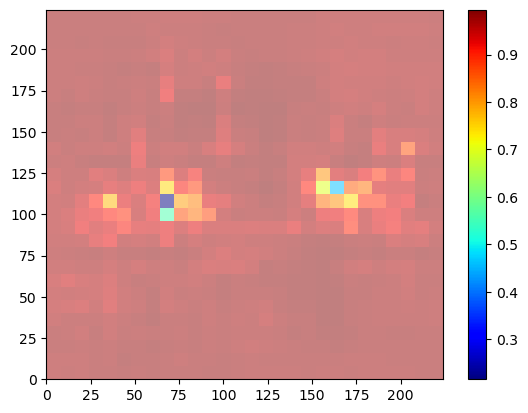

In [83]:

# take example image
image = X_train[5]
correct_class = np.argmax(y_train[5])

# define variables to use
img_size = image.shape[0]
occlusion_size = 8
heatmap = np.zeros((img_size, img_size), np.float32)
class_pixels = np.zeros((img_size, img_size), np.int16)

from collections import defaultdict
counters = defaultdict(int)

for n, (x, y, img_float) in enumerate(iter_occlusion(image, size=occlusion_size)):

    X = img_float.reshape(1, 224, 224, 3)
    out = model.predict(X, verbose=0)

    heatmap[y:y + occlusion_size, x:x + occlusion_size] = out[0][correct_class]
    class_pixels[y:y + occlusion_size, x:x + occlusion_size] = np.argmax(out)
    counters[np.argmax(out)] += 1

plt.imshow(image)

plt.show()

plt.pcolormesh(heatmap, cmap=plt.cm.jet, alpha=0.50)
plt.colorbar().solids.set(alpha=1)
